In [1]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict


from tqdm import tqdm
from glob import glob

import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({'font.size': 16})

In [2]:
model_colors = {'Species-aware':"#E69F00",'Species-agnostic':"#56B4E9",
                'Species-aware-tempscale':"#E69F00",'Species-agnostic-tempscale':"#56B4E9",
                'DNABERT':"#CC79A7", '11-mer':"#F0E442",'13-mer':"#F0E442",'PhyloP-100way':"#0072B2",'PhyloP-241way':"#D55E00",'NT-MS-v2-500M':"#009E73"}

In [3]:
data_dir = '/lustre/groups/epigenereg01/workspace/projects/vale/MLM/motif_predictions/'

In [4]:
models = { 'DNABERT': 'dnabert/default/*.pickle', 
          'NT-MS-v2-500M': 'split_75_25/ntrans/NT-MS-v2-500M/*.pickle','13-mer':'K-mer/13_mer.pickle',
          'Species-agnostic':'species_agnostic/probas.pickle','Species-aware':'species_aware/probas.pickle', 
          'PhyloP-100way': '../PhyloP/PhyloP100_3UTR.pickle' ,'PhyloP-241way': '../PhyloP/PhyloP241_3UTR.pickle', }

In [5]:
def get_model(glob_path):
    res = {}
    for probas_file in glob(glob_path):
        #print(probas_file)
        with open(probas_file, 'rb') as f:
            model_probas = pickle.load(f)
            if len(model_probas)==2:
                res.update({model_probas[0]:model_probas[1]})
            else:
                res.update(dict(model_probas))
    return res

In [6]:
all_model_probas = {}

for model_name in models:
    all_model_probas[model_name] = get_model(data_dir + models[model_name])
    print(f'{model_name} loaded, {len(all_model_probas[model_name])} sequences')

DNABERT loaded, 18134 sequences
NT-MS-v2-500M loaded, 4245 sequences
13-mer loaded, 18134 sequences
Species-agnostic loaded, 18134 sequences
Species-aware loaded, 18134 sequences
PhyloP-100way loaded, 18178 sequences
PhyloP-241way loaded, 18178 sequences


In [7]:
mapping = {'A':0,'C':1,'G':2,'T':3}

In [8]:
human_fasta = data_dir + '../fasta/240_species/species/Homo_sapiens.fa' #3'UTR on hegative strand should  be reverse complemented

human_utr = defaultdict(str)

with open(human_fasta, 'r') as f:
    for line in f:
        if line.startswith('>'):
            seq_name = line[1:].split(':')[0]
        else:
            human_utr[seq_name] += line.rstrip().upper()

In [9]:
def inv_mapping(i):
    indices = [0,1,2,3]
    indices.remove(i)
    return indices 

prob_ref = {model_name:[] for model_name in models}
inv_prob_alt = {model_name:[] for model_name in models}
ref_alt_ratio = {model_name:[] for model_name in models}

step_bp=10

for seq_name, seq in tqdm(human_utr.items()):
    for model_name in models:
        if seq_name in all_model_probas[model_name]:
            if 'PhyloP' in model_name:
                ref_probas = all_model_probas[model_name][seq_name][::step_bp]
            else:
                ref_probas = np.array([all_model_probas[model_name][seq_name][idx,mapping[seq[idx]]] for idx in range(0,len(seq),step_bp)])
                inv_alt_probas = np.array([1./all_model_probas[model_name][seq_name][idx,inv_mapping(mapping[seq[idx]])].flatten() for idx in range(0,len(seq),step_bp)])
                ratio = np.repeat(ref_probas[...,None],3,1)*inv_alt_probas
                inv_prob_alt[model_name].append(inv_alt_probas.reshape(-1)[::3])
                ref_alt_ratio[model_name].append(ratio.reshape(-1)[::3])
            prob_ref[model_name].append(ref_probas)

        
for model_name in models:
    prob_ref[model_name] = np.hstack(prob_ref[model_name])
    if not 'PhyloP' in model_name:
        inv_prob_alt[model_name] = np.hstack(inv_prob_alt[model_name])
        ref_alt_ratio[model_name] = np.hstack(ref_alt_ratio[model_name])

100%|██████████| 18134/18134 [01:35<00:00, 189.42it/s]


In [10]:
scores = {'$p_{ref}$':prob_ref, 'log($p_{alt}^{-1}$)':inv_prob_alt, 'log($p_{ref}$/$p_{alt}$)': ref_alt_ratio}

$p_{ref}$
"DNABERT":[0.16,0.692],"NT-MS-v2-500M":[0.0547,0.829],"13-mer":[0.113,0.632],"Species-agnostic":[0.166,0.556],"Species-aware":[0.167,0.554],"PhyloP-100way":[-0.885,2.02],"PhyloP-241way":[-0.915,3.01],
log($p_{alt}^{-1}$)
"DNABERT":[0.916,3.51],"NT-MS-v2-500M":[0.638,3.94],"13-mer":[0.807,3.63],"Species-agnostic":[0.928,3.12],"Species-aware":[0.983,3.02],
log($p_{ref}$/$p_{alt}$)
"DNABERT":[-0.692,2.79],"NT-MS-v2-500M":[-1.59,3.17],"13-mer":[-1.04,3.01],"Species-agnostic":[-0.655,2.27],"Species-aware":[-0.579,2.13],


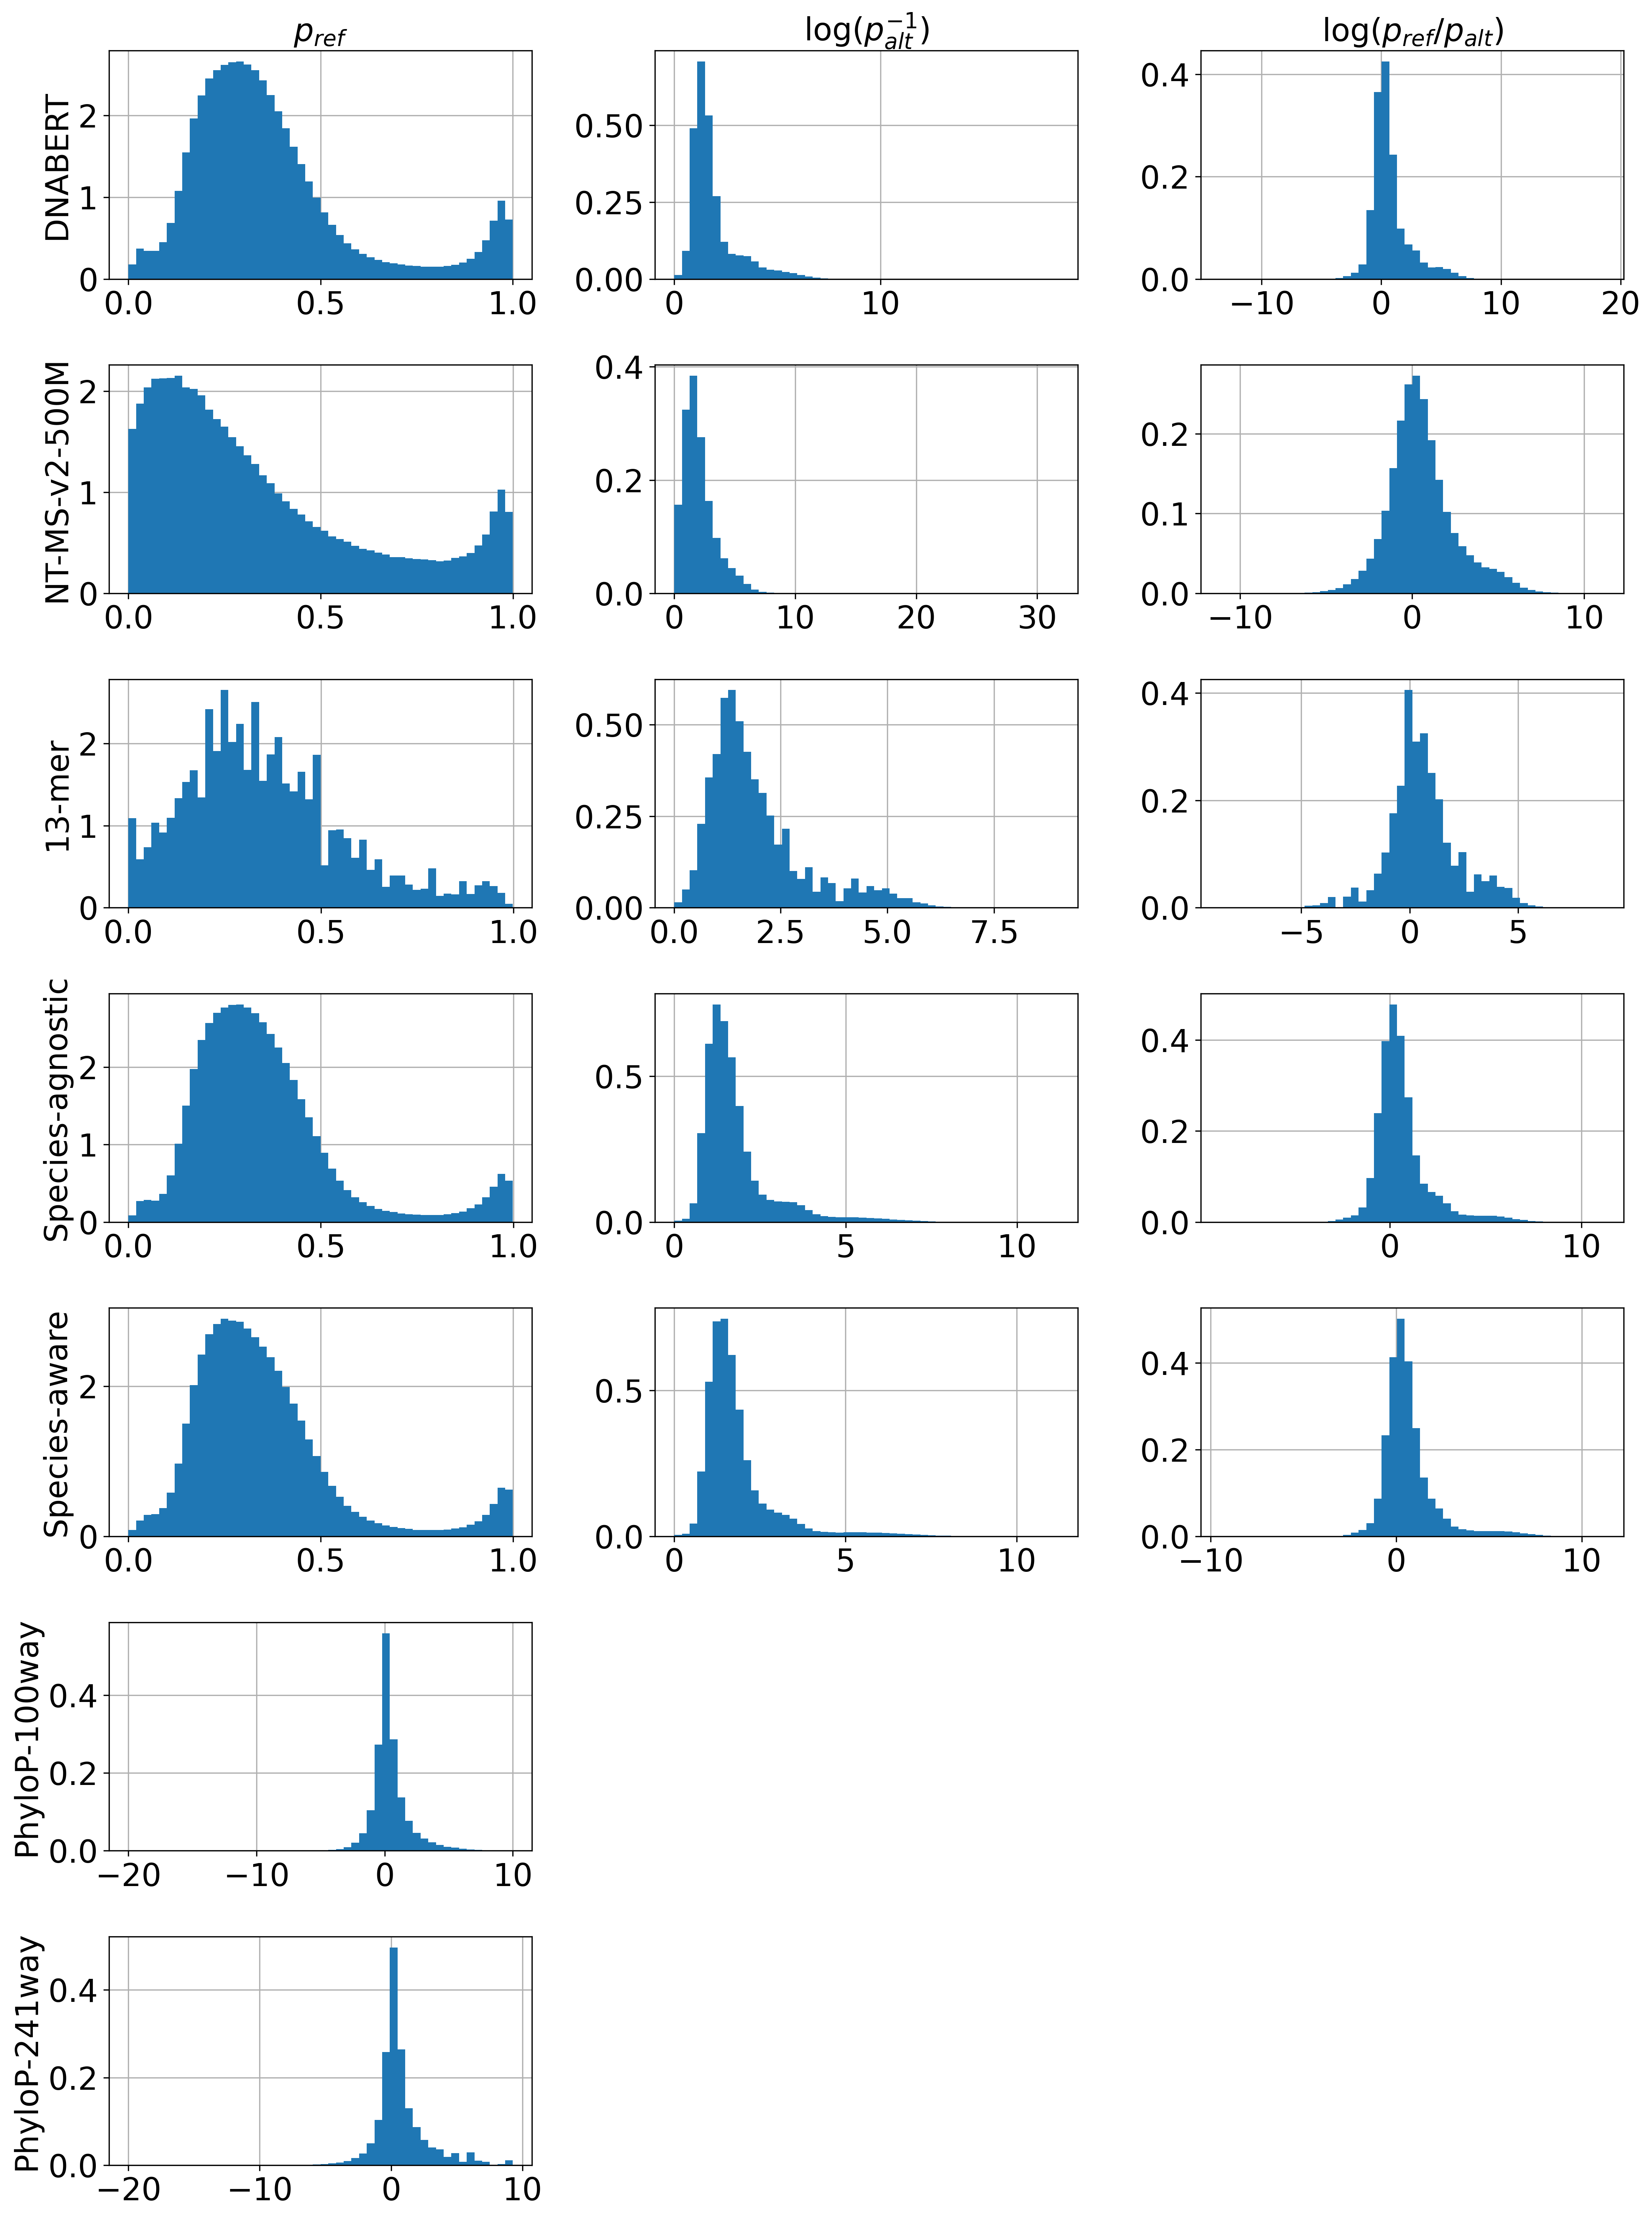

In [13]:
matplotlib.rcParams.update({'font.size': 20})

N_models = len(models)
N_scores = 3

#fig, axes = plt.subplots(N_scores,N_models,figsize=(20,5),dpi=300)
fig, axes = plt.subplots(N_models,N_scores,figsize=(15,20),dpi=300)

for col,score in enumerate(scores):
    print(score)
    for row,model_name in enumerate(models):
        ax = axes[row,col]
        data = scores[score][model_name]
        if len(data)>0:
            if score=='log($p_{alt}^{-1}$)' or score=='log($p_{ref}$/$p_{alt}$)':
                data = np.log(data)
            ax.hist(data, density=True, bins=50)
            ax.grid(True)
            ax.set_axisbelow(True)
            if row==0:
                ax.set_title(score, fontsize=20)
            if col==0:
                ax.set_ylabel(model_name, fontsize=20)
            #ax.axvline(x=np.percentile(data,70), color='r', linestyle='--')
            #ax.axvline(x=np.percentile(data,10), color='r', linestyle='--')
            print(f'"{model_name}":[{np.nanpercentile(data,10):.3},{np.nanpercentile(data,90):.3}],',end='')
        else:
            ax.set_axis_off()
    print()
fig.tight_layout()